# Analisi Fianziaria di Criptovalute

# 0. Analisi del Mercato

# 1. Estrazione dei Dati
I dati sono stati estratti dal sito *Yahoo Finance* usando delle REST API. I dati sono stati scaricati per tre criptovalute: <br>
* *Ethereum*
* *Bitcoin*
* *Dash*
* *XRP*

I dati sono stati scaricati per l'intervallo temporale tra *2018-01-01* e *2023-10-01* <br>

In [291]:
import DataExtractor

cryptoList : list[str] = ["ETH-USD", "BTC-USD", "DASH-USD", "XRP-USD"]

startDate : str = "2018-01-01"
endDate : str = "2023-09-01"
interval : str = "daily"

for crypto in cryptoList :
    DataExtractor.extractData(crypto, startDate, endDate, interval)

In [292]:
import os, pandas as pd

In [293]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "data", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

Per tenere conto dell'inflazione degli ultimi anni consideriamo una correzione sui prezzi fatta usando il Consumer Price Index, ottenuto estraendo i dati dal sito della FRED.
I dati estratti da quest'ultimo sito sono mensili, mentre i dati scaricati per le criptovalute sono periodici. Per rendere i dati omogenei procediamo facendo un'interpolazione lineare del CPI, ottenendo per ogni giorno il PCI.

In [294]:
cpiDataFrame = pd.read_csv(
    os.path.join("./", "data", "ConsumerPriceIndex.csv"),
    date_format = "%Y-%m-%d",
    parse_dates = ["DATE"]
    )
cpiDataFrame["DATE"] = pd.to_datetime(cpiDataFrame["DATE"])
cpiDataFrame

,DATE,CPIAUCSL
0,2018-01-01,248.859
1,2018-02-01,249.529
2,2018-03-01,249.577
3,2018-04-01,250.227
4,2018-05-01,250.792
...,...,...
64,2023-05-01,303.294
65,2023-06-01,303.841
66,2023-07-01,304.348
67,2023-08-01,306.269


In [316]:
cpiInterpolatedDataFrame : pd.DataFrame = pd.DataFrame(columns = ["Date", "CPI"])

for i in range(0, cpiDataFrame.shape[0] - 1) :
    firstValue = cpiDataFrame.iloc[i]["CPIAUCSL"]
    secondValue = cpiDataFrame.iloc[i + 1]["CPIAUCSL"]
    valueDiff = secondValue - firstValue

    firstDate = cpiDataFrame.iloc[i]["DATE"]
    secondDate = cpiDataFrame.iloc[i + 1]["DATE"]
    dateDiff = secondDate - firstDate

    diffDays = dateDiff.days
    interValue = valueDiff / diffDays

    interpolatedValue = firstValue
    currDate = firstDate
    for dateIncr in range(1, diffDays + 1) :
        newRow = [currDate, interpolatedValue]
        cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = newRow

        interpolatedValue = interpolatedValue + interValue
        currDate = currDate + pd.Timedelta(days = 1)

lastDate = currDate
lastValue = interpolatedValue

cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = [lastDate, lastValue]
cpiInterpolatedDataFrame

,Date,CPI
0,2018-01-01,248.859000
1,2018-01-02,248.880613
2,2018-01-03,248.902226
3,2018-01-04,248.923839
4,2018-01-05,248.945452
...,...,...
2065,2023-08-28,307.324613
2066,2023-08-29,307.363710
2067,2023-08-30,307.402806
2068,2023-08-31,307.441903


## 2. Analisi del Dataset

### 2_1. Passaggio al Logaritmo

In [296]:
import numpy as np

In [297]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [298]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "Close")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.887978
1       2.946670
2       2.983500
3       2.991634
4       2.999009
          ...   
2065    3.218130
2066    3.237977
2067    3.231753
2068    3.216335
2069    3.211785
Name: LogClosePrice, Length: 2070, dtype: float64

In [299]:
import matplotlib.pyplot as plt

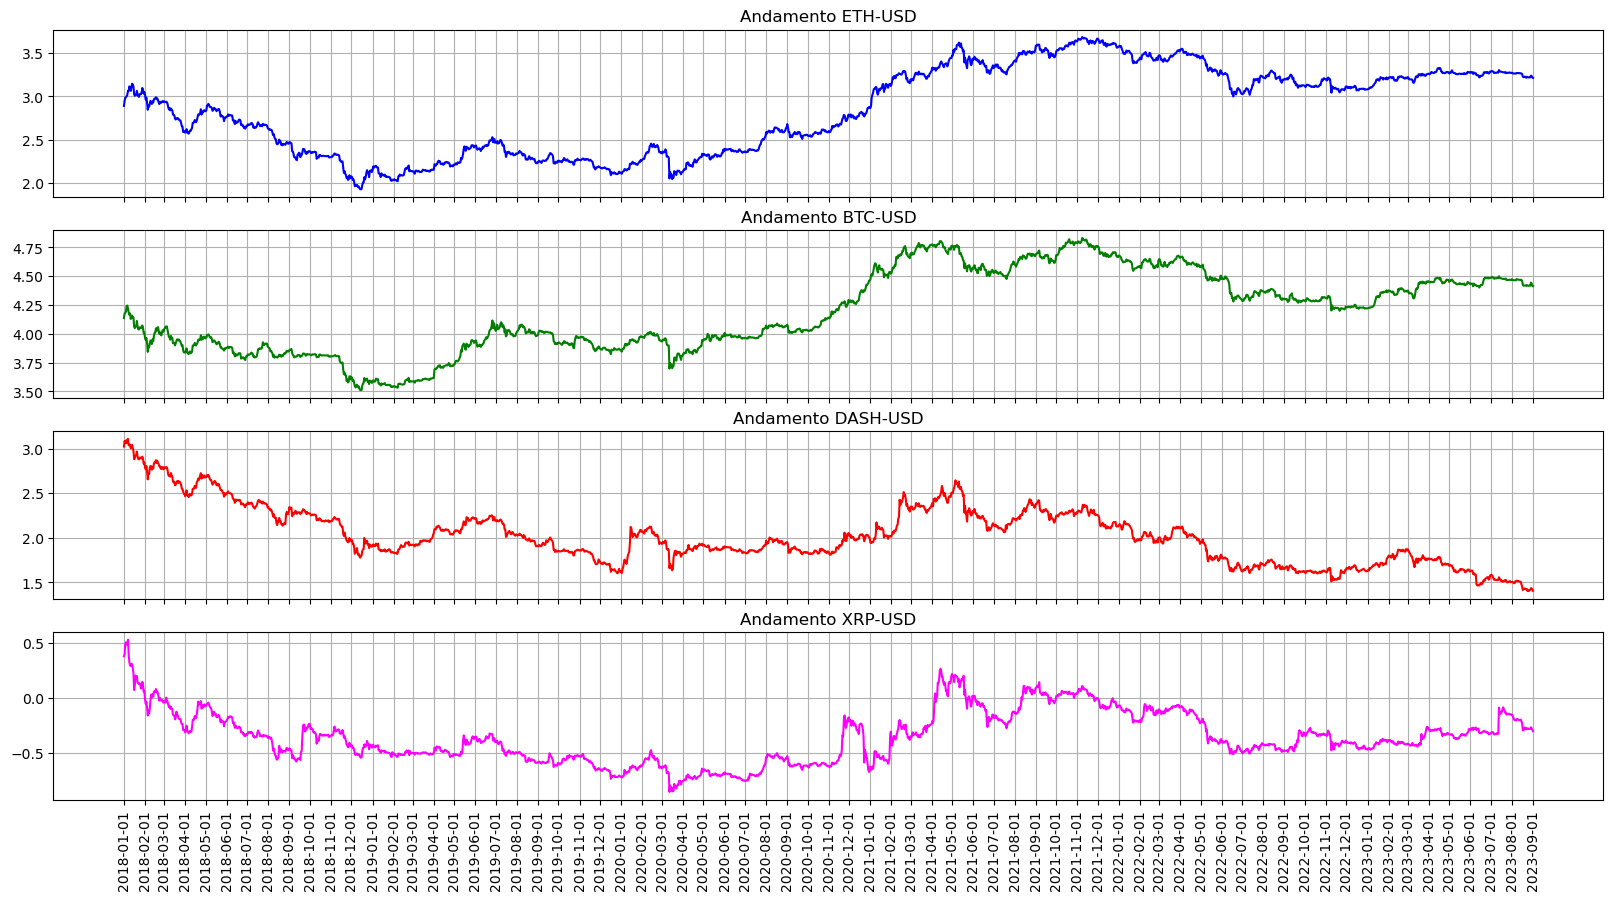

<Figure size 640x480 with 0 Axes>

In [300]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

### 2_2. Ricerca di una componenti di Random Walk
Le componenti di Random Walk vengono ricercate usando due Test di Ipotesi:
* Adfuller
* KPSS

Nel test di KPSS abbiamo:
* $H_0$ : La serie è stazionaria attorno a una tendenza deterministica (NON ha componente di Random Walk)
* $H_1$ : La serie non è stazionaria (HA componente di Random Walk)

Nel test di Adfuller abbiamo:
* $H_0$ : La serie ha una radice unitaria (HA componente di Random Walk)
* $H_1$ : La serie non ha una radice unitaria (NON ha componente di Random Walk)

Nel nostro caso vogliamo:
* KPSS, **Rigettare**
* Adfuller, **Accettare**

In [301]:
from rich.console import Console
from rich.table import Table

In [302]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table :
    table = Table(title = "Test " + testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

In [303]:
from statsmodels.tsa.stattools import adfuller, kpss

In [304]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(cryptoDataFrameDict[crypto]["LogClosePrice"])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(cryptoDataFrameDict[crypto]["LogClosePrice"])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                     Test KPSS                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  4.627246368955383 │   0.01 │ Reject  │
│ BTC-USD  │   4.81298295966102 │   0.01 │ Reject  │
│ DASH-USD │ 2.7024272353426806 │   0.01 │ Reject  │
│ XRP-USD  │ 0.9365107881400174 │   0.01 │ Reject  │
└──────────┴────────────────────┴────────┴─────────┘

                          Test Adfuller                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃              pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -0.9499272821063957 │  0.7710865697810987 │ Accept  │
│ BTC-USD  │ -1.0058388849470457 │  0.7511287491426532 │ Accept  │
│ DASH-USD │  -2.813655647224708 │ 0.05634947639288474 │ Accept  │
│ XRP-USD  │  -3.467548114653029 │  0.0088607059830442 │ Reject  │
└──────────┴─────────────────────┴─────────────────────┴─────────┘

### 2_3. Differencing della serie storica e analisi del rumore
Procediamo lo studio con l'analisi del rumore.

Passiamo al differencing della serie storica, ottenendo $Y_{t+1} - Y_{t} = W_{t}$ e procedendo con un'analisi del termine $W_{t}$.

Il differencing viene fatto sul risultato del passaggio al logaritmo dei valori originari. Siano:
* *Y*, valori logaritmici
* *P*, valori originari
* *R*, rendimento

Fare il differencing dei valori logaritmici ci permette di fare quanto segue:

$Y_{t+1} - Y_{t} = \log(P_{t+1}) - \log(P_t) = \log(\frac{P_{t+1}}{P_{t}}) = \log(R) = W_t$

Ovvero analizzare se il rendimento ha o meno natura di rumore bianco

In [305]:
differencingDict : dict[str, pd.Series] = {}
for crypto in cryptoDataFrameDict :
    logPriceSeries : pd.Series = cryptoDataFrameDict[crypto]["LogClosePrice"]
    differencing : pd.Series = logPriceSeries.diff()
    differencing.dropna(inplace = True)
    differencing.reset_index(inplace = True, drop = True)
    differencingDict[crypto] = differencing

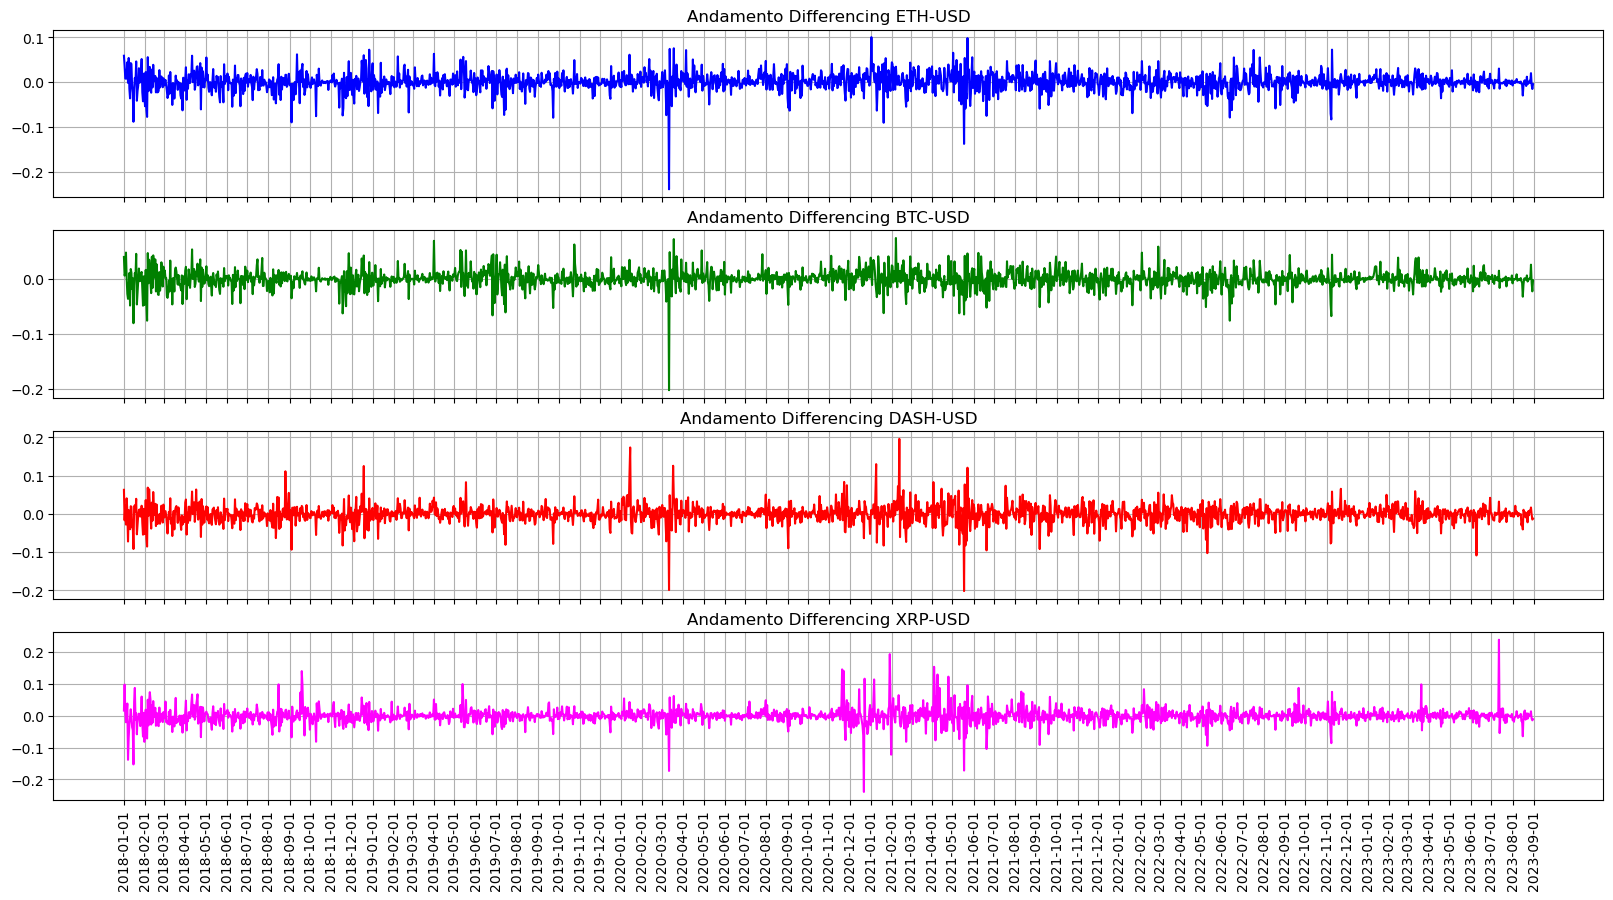

<Figure size 640x480 with 0 Axes>

In [306]:
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

### Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [307]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(differencingDict[crypto])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                      Test KPSS                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.23452313535968247 │    0.1 │ Accept  │
│ BTC-USD  │ 0.15992517917293175 │    0.1 │ Accept  │
│ DASH-USD │ 0.13976373680392282 │    0.1 │ Accept  │
│ XRP-USD  │ 0.20011221882434005 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                            Test Adfuller                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -13.696262850312285 │ 1.3151855826691877e-25 │ Reject  │
│ BTC-USD  │  -15.93309699375771 │  7.689731324491407e-29 │ Reject  │
│ DASH-USD │ -21.682508522767034 │                    0.0 │ Reject  │
│ XRP-USD  │  -46.75643946220794 │                    0.0 │ Reject  │
└──────────┴─────────────────────┴────────────────────────┴─────────┘

Dal test di KPSS e dal test ADF, possiamo concludere che il differencing $W_t$ è stazionario

### Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [308]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import kurtosis

In [309]:
# Crea il modello
SIGNIFICANCE_LEVEL = 0.05
bpTable = buildTable("Breusch-Pagan", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
whiteTable = buildTable("White", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])

for crypto in cryptoList :
    x = sm.add_constant(differencingDict[crypto].index.tolist())
    model = sm.OLS(differencingDict[crypto].values, x)
    fittedModel = model.fit()
    print(crypto)
    print(fittedModel.summary())
    residKurtosis = kurtosis(fittedModel.resid)

    # In the general description of LM test, Greene mentions that this test exaggerates the significance of results in small or moderately large samples. 
    # In this case the F-statistic is preferable.

    # BREUSCH-PAGAN TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_breuschpagan(fittedModel.resid, fittedModel.model.exog, not (residKurtosis > 0.05))
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    bpTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    # WHITE TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_white(fittedModel.resid, fittedModel.model.exog)
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    whiteTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

ETH-USD
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5556
Date:                Thu, 09 Nov 2023   Prob (F-statistic):              0.456
Time:                        15:43:14   Log-Likelihood:                 5050.9
No. Observations:                2069   AIC:                        -1.010e+04
Df Residuals:                    2067   BIC:                        -1.009e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.476 

In [310]:
console = Console()
console.print(bpTable)
console.print(whiteTable)

                        Test Breusch-Pagan                        
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │   8.60596366026681 │ 0.003387533450114748 │ Reject  │
│ BTC-USD  │    7.8327926421415 │ 0.005178285645440958 │ Reject  │
│ DASH-USD │ 2.2864072977744647 │  0.13066458033467923 │ Accept  │
│ XRP-USD  │ 1.2590908717567904 │   0.2619535743736796 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

                            Test White                             
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  5.274627721439546 │ 0.0051890381227510385 │ Reject  │
│ BTC-USD  │  4.178138081645586 │  0.015456723166505398 │ Reject  │
│ DASH-USD │  3.670356586873677 │  0.025633596829634394 │ Reject  │
│ XRP-USD  │ 0.7602339019720028 │   0.46768780313712877 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

### Analisi Autocorrelazione

Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box
* Durbin-Watson

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Per il test Durbin-Watson:
* $H_0$: Non c'è autocorrelazione di primo ordine nei residui del modello. In altre parole, l'autocorrelazione tra i residui ad uno e due intervalli di tempo di distanza è zero.
* $H_1$: C'è autocorrelazione di primo ordine nei residui del modello. I residui consecutivi sono correlati in qualche modo.

Vogliamo quindi :
* Ljung-Box, **Accettare**
* Durbin-Watson, **Accettare**

In [311]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [312]:
model = sm.tsa.ARIMA(cryptoDataFrameDict["ETH-USD"]["LogClosePrice"], order = (1, 0, 1))
fittedModel = model.fit()
testResult = acorr_ljungbox(fittedModel.resid, lags = 1)
print(testResult["lb_pvalue"])

STATVALUE_LIMIT = 2
SIGNIFICANCE_LEVEL = 0.1

durbinWatsonTable = buildTable("Durbin-Watson", ["Crypto", "StatValue", "Outcome"], ["left", "right", "left"])
for crypto in cryptoList :
    data = cryptoDataFrameDict[crypto]["LogClosePrice"]
    x = sm.add_constant(data.index.tolist())
    model = sm.OLS(data.values, x)
    fittedModel = model.fit()
    statValue = durbin_watson(fittedModel.resid)
    outcomeString = "Accept" if (pValue > STATVALUE_LIMIT - SIGNIFICANCE_LEVEL) and (pValue < STATVALUE_LIMIT - SIGNIFICANCE_LEVEL) else "Reject"
    durbinWatsonTable.add_row(crypto, str(statValue), outcomeString)

console = Console()
console.print(durbinWatsonTable)

1    0.806586
Name: lb_pvalue, dtype: float64


             Test Durbin-Watson              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃            StatValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  0.00362132738844604 │ Reject  │
│ BTC-USD  │ 0.004925109934819093 │ Reject  │
│ DASH-USD │  0.00947509664460447 │ Reject  │
│ XRP-USD  │ 0.011854887486579509 │ Reject  │
└──────────┴──────────────────────┴─────────┘

Tracciamo gli autocorrelogrammi e gli autocorrelogrammi parziali dei dati.

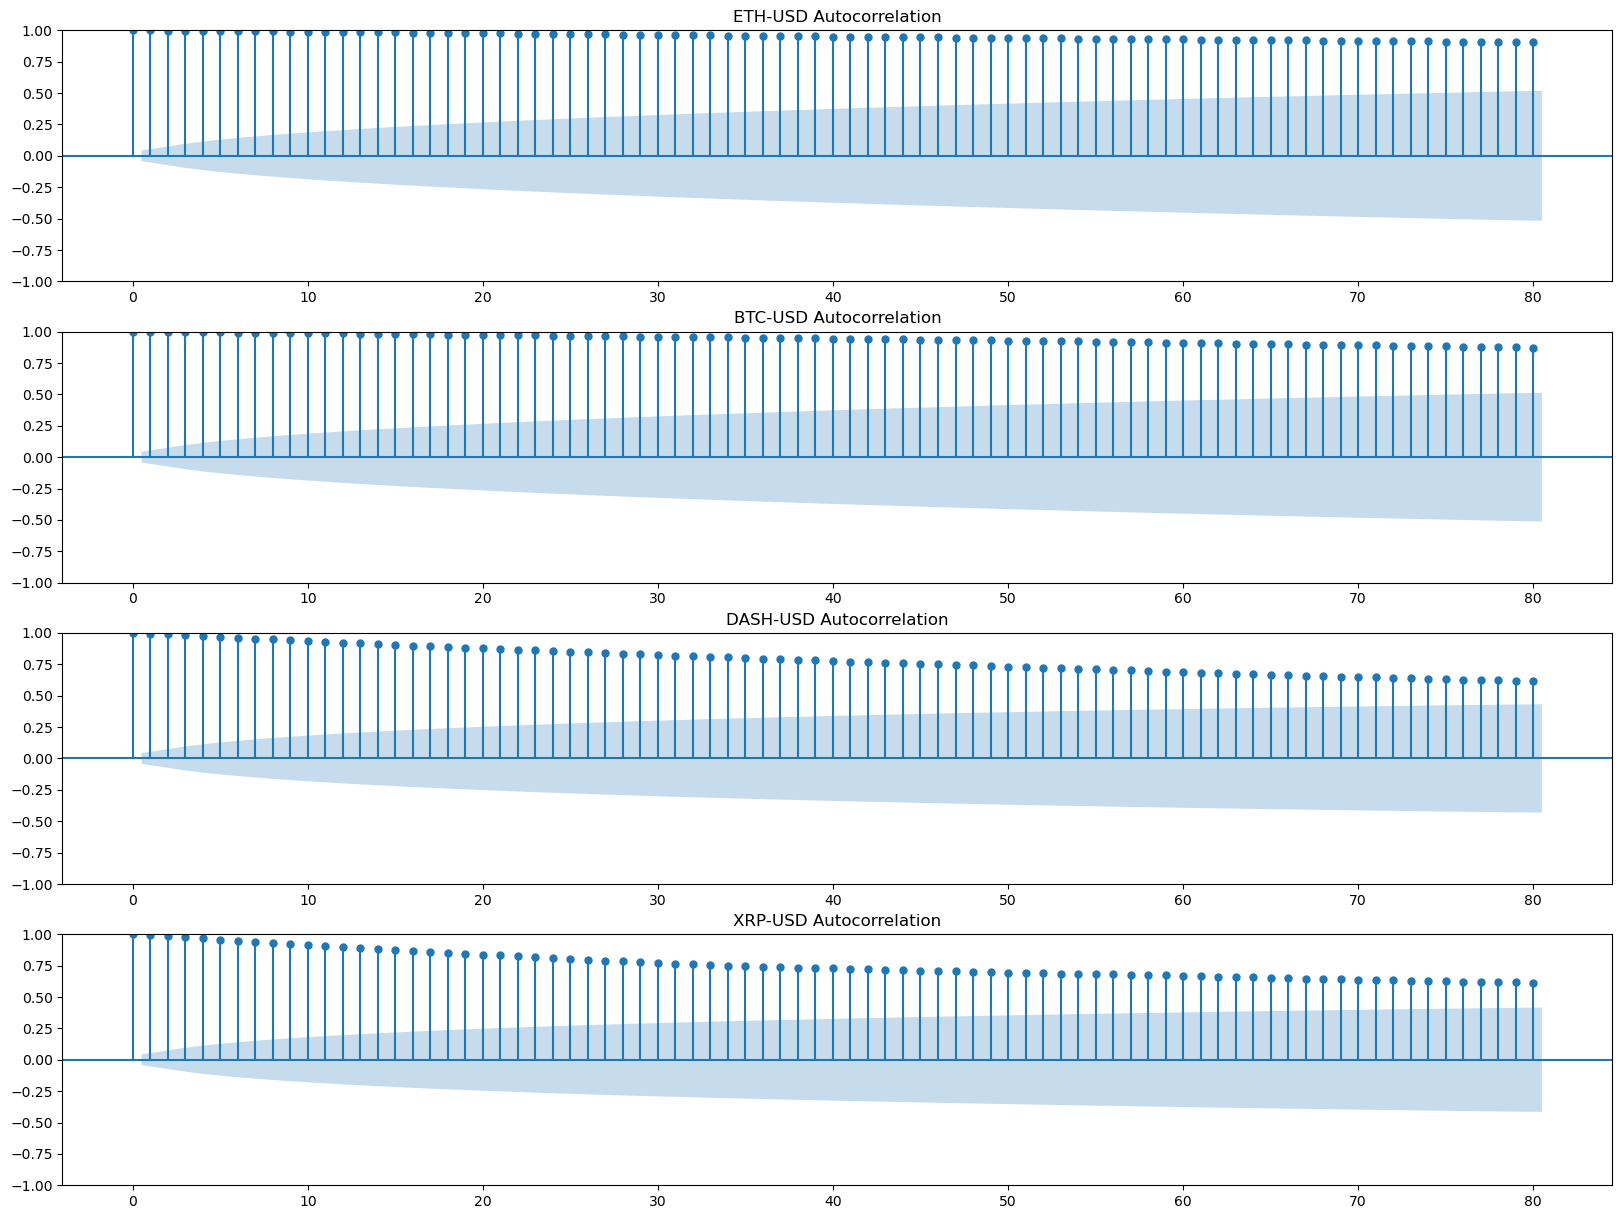

<Figure size 640x480 with 0 Axes>

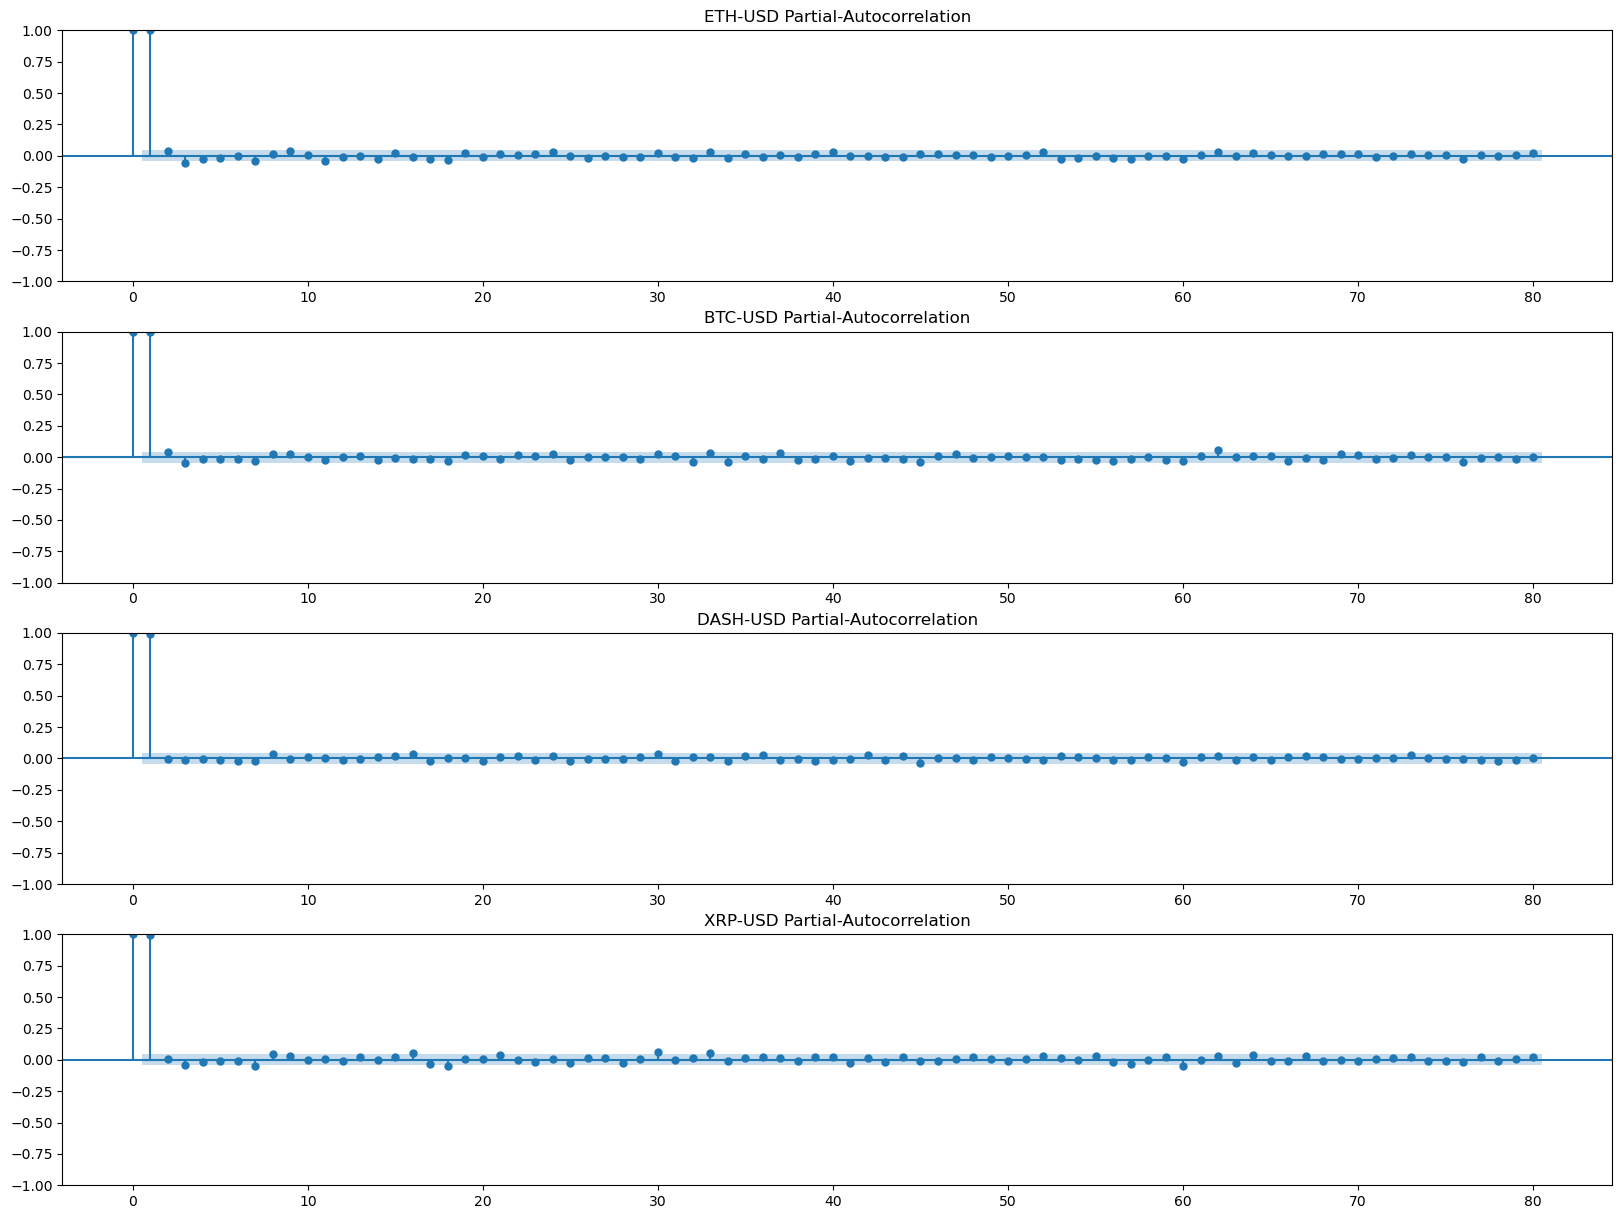

<Figure size 640x480 with 0 Axes>

In [313]:
fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 1)
i = 0 
for crypto in cryptoList :
    plot_acf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i], lags = 80, title = crypto + " Autocorrelation")
    i += 1
plt.show()
plt.clf()

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 1)
i = 0 
for crypto in cryptoList :
    plot_pacf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i], lags = 80, title = crypto + " Partial-Autocorrelation")
    i += 1
plt.show()
plt.clf()

Stando a queste prove possiamo rigettare in entrambi i casi l'ipotesi nulla di assenza di autocorrelazione.

### Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* *H0*: I dati seguono una distribuzione normale
* *H1*: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* *H0*: I dati seguono la distribuzione specificata
* *H1*: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [314]:
#%%capture --no-display

from scipy.stats import shapiro, kstest, norm

SIGNIFICANCE_LEVEL = 0.05

# Esegue il test di normalità di Shapiro-Wilk
shapiroTable = buildTable("Shapiro-Wilk", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = shapiro(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    shapiroTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(shapiroTable)

ksTable = buildTable("Kolmogorov-Smirnov", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = kstest(differencingDict[crypto], norm.cdf)
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ksTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(ksTable)


                         Test Shapiro-Wilk                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │   0.92220139503479 │ 1.9984819259177278e-31 │ Reject  │
│ BTC-USD  │ 0.9065768122673035 │  7.724262459684524e-34 │ Reject  │
│ DASH-USD │ 0.9036797285079956 │ 2.9929971095494083e-34 │ Reject  │
│ XRP-USD  │ 0.8353574872016907 │  6.650562511685582e-42 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

               Test Kolmogorov-Smirnov               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.47054389737455127 │    0.0 │ Reject  │
│ BTC-USD  │  0.4760877471387236 │    0.0 │ Reject  │
│ DASH-USD │  0.4660896215914345 │    0.0 │ Reject  │
│ XRP-USD  │ 0.46420296730298866 │    0.0 │ Reject  │
└──────────┴─────────────────────┴────────┴─────────┘

Notiamo quindi che i due test ci fanno rigettare in entrambi i casi l'ipotesi nulla di normalità dei dati.
Per completezza tracciamo un grafico dei dati.